*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module02_04_nearest_neighbors.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
%autosave 0

Autosave disabled


# Nearest neighbor classification

The nearest neighbor classifier is one of the simplest machine learning methods available.
Here's the simplest version of it:

```
Nearest neighbor classifier

- Find the example in the training data that is closest to
  the example that needs to be classified.
- Return its label
```

## Measuring distance

To implement this idea we need to define a concrete notion of closeness.
We'll do that using the **distance** between examples. 

First recall that the *norm* of a vector was defined as:

$$
||\mathbf{x}||^2 = \mathbf{x}^\top \mathbf{x}.
$$

Using this notation, we can define the **Euclidean distance** $d_2(\mathbf{x}, \mathbf{x}')$ between vectors $\mathbf{x}$ and $\mathbf{x}'$ as:

$$
d_2(\mathbf{x}, \mathbf{x}')^2 = ||\mathbf{x} - \mathbf{x}'||^2 = 
(\mathbf{x} - \mathbf{x}')^\top (\mathbf{x} - \mathbf{x}') = 
\sum_{i=1}^d (x_i - x_i')^2.
$$

Here are some Numpy implementations that directly reflect the different ways of expressing this definition:

In [3]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

distance(np.array([2,1]), np.array([1,0]))

1.4142135623730951

In [4]:
def distance2(x1, x2):
    return np.sqrt(np.dot(x1-x2, x1-x2))

distance2(np.array([2,1]), np.array([1,0]))

1.4142135623730951

In [5]:
def distance3(x1, x2):
    return np.sqrt(np.sum( (x1-x2)**2) )

distance3(np.array([2,1]), np.array([1,0]))

1.4142135623730951

Now we are ready to implement the nearest neighbor classifier:

In [11]:
class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i]) for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, x) :
        return self.y[self.get_nearest(x)]

Let's apply this classifier to the digit classification dataset bundled with scikit-learn.  This dataset is originally from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), and addresses handritten image recognition.

In [6]:
from sklearn import datasets
digits = datasets.load_digits()

In [23]:
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


Each pixel in an image corresponds to a feature, so 8 x 8 images yield a feature matrix which has 64 dimensions.  Each element in the feature matrix is an integer between 0 and 16:

In [16]:
X.max(),X.min()

(16.0, 0.0)

Let's visualize the first 10 examples in the dataset as images:

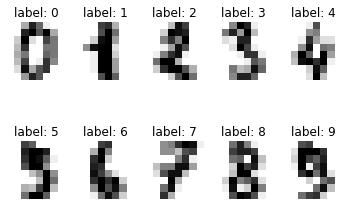

In [8]:
num_plots = 10
fig, axes = plt.subplots(2, 5);
for i in range(num_plots) :
    ax = axes[i // 5][i % 5]
    ax.set_axis_off()
    ax.imshow(np.resize(X[i], (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('label: %i' % y[i])

A scatter plot of the data will show us that individual features do carry some information about the labels:

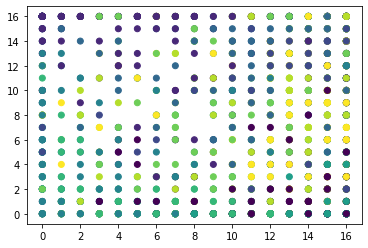

In [26]:
plt.scatter(X[:, 10], X[:, 20], c=y);

Later in the course we will see ways of visualizing high dimensional data in two or three dimensions, which will help us get a better picture of what's going on overall.

Before using the nearest neighbor classifier we need to split the data into training and test sets:

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape)

(1257, 64) (540, 64)


Now we are ready to classify our data:

In [12]:
nn = nearest_neighbor()
nn.fit(X_train, y_train)
y_pred = np.array([nn.predict(X_test[i]) for i in range(len(X_test))])

How accurate is our classifier?

In [13]:
np.sum(y_pred == y_test)/len(y_test)

0.9833333333333333

Next, let's plot training examples and their closest test examples:

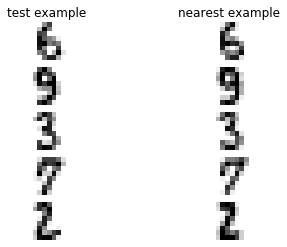

In [14]:
num_plots = 5
fig, axes = plt.subplots(5, 2);
for i in range(num_plots) :
    ax_test = axes[i][0]
    ax_nearest = axes[i][1]
    ax_test.set_axis_off()
    ax_nearest.set_axis_off()
    ax_test.imshow(np.resize(X_test[i], (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    nearest = X_train[nn.get_nearest(X_test[i])]
    ax_nearest.imshow(np.resize(nearest, (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    if (i==0):
        ax_test.set_title('test example')
        ax_nearest.set_title('nearest example')

### The decision boundary 

To obtain a better understanding of the nearest neighbor classifier let us consider the question of the shape of its decision boundary.  While the decision boundary of classifiers such as the perceptron are linear, the nearest neighbor classifier is more flexible as we see next.

First, here's a function for plotting the decision boundary of a classifier:

In [20]:
from matplotlib.colors import ListedColormap

def plot_boundary(classifier, X, y, axes = None) :
    """
    code based on:
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    """
    classifier.fit(X, y)
    # color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    # create a two dimensional grid of points
    h = .02  # grid size
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # plot the predictions on the grid
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.5)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    

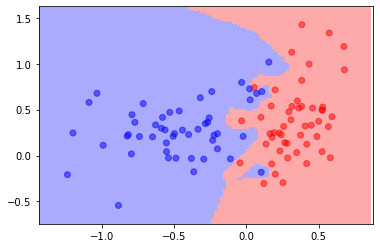

In [21]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.35, random_state=1)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(1)

plot_boundary(classifier, X, y)

To further highlight the way the nearest neighbor classifier works, here's random data in two dimensions:

In [ ]:
X_random = rng.random(size=(100, 2))
y_random = rng.integers(0, 2, len(X_random))
print(X_random.shape, y_grid.shape)
classifier = KNeighborsClassifier(1)
plot_boundary(classifier, X_random, y_random)

### Voronoi diagrams

<img style="padding: 10px; float:left;" alt="20 points and their Voronoi cells by Balu Ertl CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/5/54/Euclidean_Voronoi_diagram.svg" width="250">

Turns out that the decision boundary of a nearest neighbor classifier is related to the concept of a *Voronoi diagram*.

Given a collection of points $\{\mathbf{x}_1,\ldots,\mathbf{x}_N\}$,
the Voronoi cell associated with point $\mathbf{x}_i$ is the set of points that are closer to $\mathbf{x}_i$ than every other point in the collection.

For nearest neighbor classification we obtain the decision boundary by merging adjacent Voronoi cells that have the same label associated with them.

### Question:

What accuracy do you expect for a nearest neighbor classifier that is tested on the training set?

### Exercise:  Accuracy with increasing levels of noise

The nearest neighbor classifier is not robust to the existence of noisy features.  To demonstrate that, use the dataset below and add increasing number of noisy features.  Compute the accuracy of the classifier as you add an increasing number of noise features.

Noise features can be added using the numpy [normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal) method of a random number generator, which samples random numbers from a normal distribution.
For example:

In [ ]:
from numpy.random import default_rng
rng = default_rng(1)
# parameters of rng.normal:
# mean, standard deviation, and size of the output array
rng.normal(0, 0.5, size=(2,3))


To add the noise features to the feature matrix you can use the Numpy [hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) method.  For example to add two noise features:

In [ ]:
num_noise = 2
X_train_noise = np.hstack((X_train, 
                           rng.normal(0, 0.5, size=(len(X_train),num_noise))))
X_test_noise = np.hstack((X_test, 
                          rng.normal(0, 0.5, size=(len(X_test),num_noise))))
     

For this exercise, use the following dataset in two dimensions for which the nearest neighbor classifier performs well without noise:

In [ ]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.35, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, s=50);

X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, shuffle=True, random_state=1)
nn = nearest_neighbor()
nn.fit(X_train, y_train)
y_pred = np.array([nn.predict(X_test[i]) for i in range(len(X_test))])

np.sum(y_pred == y_test)/len(y_test)

In your code, add noise features to the dataset, as described above, where the number of noise features increases from 2 to 32, using the values `[2, 4, 8, 16, 32]`.  Plot the accuracy of the classifier as a function of the number of noise features. 

In [ ]:
# your code goes here

### Exercise:  a faster Numpy implementation

Whereas our rudimentary implementation of the nearest neighbor classifier takes in a single vector as input, the nearest neighbor implementation in scikit-learn takes a matrix of test examples, which removes the need for the computationally slow `for` loop we had to use when computing the output for an entire test set.  In this exercise, extend our nearest neighbor classifier and improve its efficiency so that no for loops would be required for computing the output for a large test set.

In [ ]:
class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def predict(self, X_test) :
        """
        make nearest neighbor predictions for a two dimensional array 
        X_test, representing a test set.
        The number of columns of X_test needs to be the same as the 
        number of columns of the training data.
        
        return:  an array of predictions for X_test
        """
        return 0
    